In [114]:
import numpy as np
import pandas as pd
import plotly_express as px
from plotly import graph_objects as go
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
file = 'ds_salaries.csv'
data = pd.read_csv(file)
data.sample(10)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
3717,2021,SE,FT,Data Engineer,65000,EUR,76833,RO,50,GB,S
1056,2023,SE,FT,Data Analyst,230000,USD,230000,US,0,US,M
2715,2022,SE,FT,Data Engineer,229998,USD,229998,US,0,US,L
2450,2022,EN,FT,Data Engineer,50000,GBP,61566,GB,100,GB,M
750,2023,SE,FT,Data Engineer,75000,USD,75000,US,0,US,M
2039,2022,SE,FT,Data Specialist,110000,USD,110000,US,0,US,M
1530,2023,SE,FT,Data Engineer,75000,USD,75000,US,0,US,M
806,2023,SE,FT,Data Engineer,140000,USD,140000,US,0,US,M
879,2023,SE,FT,Data Engineer,129000,USD,129000,US,0,US,M
187,2023,EN,FT,Data Analyst,75000,USD,75000,US,100,US,M


In [116]:
# Check the list of all job titles
data.job_title.unique()

array(['Principal Data Scientist', 'ML Engineer', 'Data Scientist',
       'Applied Scientist', 'Data Analyst', 'Data Modeler',
       'Research Engineer', 'Analytics Engineer',
       'Business Intelligence Engineer', 'Machine Learning Engineer',
       'Data Strategist', 'Data Engineer', 'Computer Vision Engineer',
       'Data Quality Analyst', 'Compliance Data Analyst',
       'Data Architect', 'Applied Machine Learning Engineer',
       'AI Developer', 'Research Scientist', 'Data Analytics Manager',
       'Business Data Analyst', 'Applied Data Scientist',
       'Staff Data Analyst', 'ETL Engineer', 'Data DevOps Engineer',
       'Head of Data', 'Data Science Manager', 'Data Manager',
       'Machine Learning Researcher', 'Big Data Engineer',
       'Data Specialist', 'Lead Data Analyst', 'BI Data Engineer',
       'Director of Data Science', 'Machine Learning Scientist',
       'MLOps Engineer', 'AI Scientist', 'Autonomous Vehicle Technician',
       'Applied Machine Learning Sc

There are many job titles which does not make it convenient for the analysis. It would be better to have less categories to explore.

I asked ChatGPT to classify the job titles into three categories:

Data Scientist
Data Analyst
Data Engineer
This saved me time from creating the corresponding dictionary. Although this was not perfect, I made some adjustments by hand. Of course, different people may interpret these categories differently.

In [117]:
# Will be used to map the jobs to their category
job_dict = {
    'Data Scientist': [
        'Data Scientist', 'Principal Data Scientist', 'Applied Scientist', 'AI Developer',
        'Research Scientist', 'Head of Data', 'Data Science Manager', 'AI Programmer',  
        'Director of Data Science', 'Machine Learning Scientist', 'Applied Machine Learning Scientist',
        'Lead Data Scientist', 'Deep Learning Researcher', 'Data Science Consultant', 
        'Machine Learning Developer', '3D Computer Vision Researcher', 'Machine Learning Researcher',
        'Data Science Tech Lead', 'Data Scientist Lead', 'Product Data Scientist', 'Data Science Lead',
        'Machine Learning Manager', 'AI Scientist', 'Head of Data Science', 'Applied Data Scientist',
        'Head of Machine Learning'
    ],
    'Data Analyst': [
        'Data Analyst', 'Data Quality Analyst', 'Compliance Data Analyst', 'Business Data Analyst',
        'Lead Data Analyst', 'Marketing Data Analyst', 'Data Analytics Specialist', 'Insight Analyst',
        'Product Data Analyst', 'BI Data Analyst', 'Data Operations Analyst', 'Data Analytics Lead',
        'Principal Data Analyst', 'Financial Data Analyst', 'BI Analyst', 'Data Analytics Manager',
        'Data Analytics Consultant', 'Data Manager', 'Manager Data Management'
    ],
    'Data Engineer': [
        'Data Engineer', 'Data Modeler', 'Analytics Engineer', 'Business Intelligence Engineer',
        'Data Strategist', 'Data DevOps Engineer', 'Big Data Engineer', 'Data Specialist',
        'BI Data Engineer', 'Data Infrastructure Engineer', 'Cloud Database Engineer', 'ETL Engineer',
        'Data Operations Engineer', 'BI Developer', 'Azure Data Engineer', 'Computer Vision Engineer',
        'Machine Learning Infrastructure Engineer', 'Cloud Data Engineer', 'ETL Developer',
        'Data Architect', 'Big Data Architect', 'Autonomous Vehicle Technician', 'ML Engineer',
        'Machine Learning Software Engineer', 'Data Analytics Engineer', 'Research Engineer',
        'Computer Vision Software Engineer', 'Data Lead', 'Data Management Specialist',
        'Applied Machine Learning Engineer', 'MLOps Engineer', 'Machine Learning Research Engineer',
        'Deep Learning Engineer', 'Machine Learning Engineer', 'Data Science Engineer',
        'Lead Machine Learning Engineer', 'NLP Engineer', 'Principal Machine Learning Engineer',
        'Software Data Engineer', 'Principal Data Architect', 'Lead Data Engineer'
    ]
}

def map_job(job):
    for k, v_list in job_dict.items():
        if job in v_list:
            return k
    return job

Cleaning the data
Steps:

Only keep years 2022 and 2023
Only keep full time jobs
Create the job_category column to map the job title to one of the defined three job categories
Remove jobs where the country location is represented by fewer than 10 occurrences
Rename the entry levels

In [118]:
def process(df):
    df = df.copy()
    
    # Filter year and employment type
    df = df[df.work_year.isin([2022, 2023])]
    df = df[df.employment_type == 'FT']
    
    # Map job title to job category
    df['job_category'] = df.job_title.map(map_job)
    
    # Filter company location
    country_counts = df.company_location.value_counts()
    idx = (country_counts > 10).values
    countries = country_counts[idx].index
    df = df[df.company_location.isin(countries)]
    df = df.reset_index(drop=True)
    
    # Rename experience levels
    entry_lvl_map = {'EN': 'Entry', 'MI': 'Middle',
                     'SE': 'Senior', 'EX': 'Expert'}
    df.experience_level.replace(entry_lvl_map, inplace=True)
    return df

df = process(data)

Exploratory data analysis
Salary distribution by job category

In [119]:
# Calculate medians
job_cats = list(job_dict.keys())
salary_meds = {}
for job_cat in job_cats:
    salary_meds[job_cat] = df[df.job_category == job_cat].salary_in_usd.median()

# Color map for job categories
job_cat_cmap = {'Data Scientist':'#9cd3f7', 'Data Analyst':'#fc88a7', 'Data Engineer':'#80c779'}

# Create the histograms
fig = px.histogram(df, x='salary_in_usd', nbins=50, color='job_category', marginal='rug',
                   color_discrete_map=job_cat_cmap,
                   labels = {'salary_in_usd': 'Yearly salary in USD', 'job_category': 'Job category'}, opacity=0.5)
fig.update_layout(bargap=0.1, title = "Yearly salary distribution in US dollars<br><sup>2022/2023</sup>")

# Plot the median vertical bars
for k, v in salary_meds.items():
    fig.add_vline(x=v, line_width=6, line_color='black')
    fig.add_vline(x=v, line_width=3, line_color=job_cat_cmap[k])

fig.show()

In [120]:
# Median values dataframe
pd.DataFrame.from_dict(salary_meds, orient='index', columns=['Median annual salary (USD)']).astype(int)

,Median annual salary (USD)
Data Scientist,150000
Data Analyst,108000
Data Engineer,145000


Insights
We observe a significant difference between salaries.
Data analysts have the smallest median salary.
The median salaries of data scientists and data engineers are comparable, with data scientists having slightly higher salaries.
Some data analysts have high salaries, exceeding $380K.

In [121]:
fig = go.Figure()

# Get the df for a single job category each time
for job in job_cats:
    
    # Prepare the temporary dataframe (filter and sort)
    temp_df = df[df.job_category == job]
    dfs = []
    sort_order = ['Entry', 'Middle', 'Senior', 'Expert']
    for x in sort_order:
        dfs.append(temp_df[temp_df.experience_level == x])
    temp_df = pd.concat(dfs)
    
    # Add box plots
    fig.add_trace(go.Box(
        y=temp_df.salary_in_usd,
        x=temp_df.experience_level,
        name=job, marker_color=job_cat_cmap[job]))

fig.update_layout(
    title="Annual salary distribution in US dollars by experience level and job category<br><sup>2022/2023</sup>",
    xaxis_title="Experience level",
    yaxis_title="Annual salary (USD)",
    boxmode='group')

fig.show()


There is a progression of the anual salaries

In [122]:
# Number of salary values for the expert experience level
df[df.experience_level == 'Expert']['job_category'].value_counts()

job_category
Data Engineer     61
Data Scientist    33
Data Analyst       5
Name: count, dtype: int64

In [123]:
levels = ['Entry', 'Middle', 'Senior', 'Expert']
job_cats = ['Data Scientist', 'Data Analyst', 'Data Engineer']

# Calculate the medians
medians = {}
for job in job_cats:
    job_medians = []
    for level in levels:
        temp_df = df[df.experience_level == level]
        temp_df = temp_df[temp_df.job_category == job]
        job_medians.append(temp_df.salary_in_usd.median())
    medians[job] = job_medians

# Plot the calculations
traces = []
for job in job_cats:
    traces.append(go.Scatter(x=levels, y=medians[job], mode='lines+markers',
                             name=job, marker=dict(color=job_cat_cmap[job])))
fig = go.Figure(data=traces)
fig.update_layout(
    title="Evolution of the median annual salary<br><sup>2022/2023</sup>",
    xaxis_title="Experience level",
    yaxis_title="Annual salary (USD)")
fig.show()

**Student's T-Test of significance
Question: Is there a significant difference between the salary distributions of job categories?

In [124]:
def ttest(df, job1, job2, p_thr, disp=True):
    sample1 = df[df.job_category == job1].salary_in_usd.values
    sample2 = df[df.job_category == job2].salary_in_usd.values
    p_val = ttest_ind(sample1, sample2)[1]
    if disp:
        print("="*26, "Student T-Test", "="*26)
        print(" "*16, job1, " | ", job2)
        print(" "*20, "➔ P_value:", round(p_val, 5))
        print("\nThe distribution difference is statistically", end=' ')
        if p_val < p_thr:
            print("SIGNIFICANT", end=' ')
        else:
            print("INSIGNIFICANT", end=' ')
        print(f"at {round((1-p_thr)*100, 4)}%")
        print('='*68, end='\n'*2)
    else:
        return p_val
    
def multiple_ttest(df, p_thr, disp=True):
    p1 = ttest(df, 'Data Scientist', 'Data Analyst', p_thr, disp)
    p2 = ttest(df, 'Data Scientist', 'Data Engineer', p_thr, disp)
    p3 = ttest(df, 'Data Analyst', 'Data Engineer', p_thr, disp)
    if not disp:
        return [p1, p2, p3]

In [125]:
ttest(df, 'Data Scientist', 'Data Analyst', 0.001)
ttest(df, 'Data Scientist', 'Data Engineer', 0.05)
ttest(df, 'Data Analyst', 'Data Engineer', 0.001)

========================== Student T-Test ==========================
                 Data Scientist  |  Data Analyst
                     ➔ P_value: 0.0

The distribution difference is statistically SIGNIFICANT at 99.9%

========================== Student T-Test ==========================
                 Data Scientist  |  Data Engineer
                     ➔ P_value: 0.07597

The distribution difference is statistically INSIGNIFICANT at 95.0%

========================== Student T-Test ==========================
                 Data Analyst  |  Data Engineer
                     ➔ P_value: 0.0

The distribution difference is statistically SIGNIFICANT at 99.9%



Insights
The salary distribution of data analysts is statistically lower than that of data scientists with 99% confidence level
The difference in salary distributions between data scientists and data engineers is statistically insignificant at the 95% confidence level

In [126]:
multiple_ttest(df[df.experience_level == 'Entry'], 0.05)


========================== Student T-Test ==========================
                 Data Scientist  |  Data Analyst
                     ➔ P_value: 0.00018

The distribution difference is statistically SIGNIFICANT at 95.0%

========================== Student T-Test ==========================
                 Data Scientist  |  Data Engineer
                     ➔ P_value: 0.2804

The distribution difference is statistically INSIGNIFICANT at 95.0%

========================== Student T-Test ==========================
                 Data Analyst  |  Data Engineer
                     ➔ P_value: 0.0

The distribution difference is statistically SIGNIFICANT at 95.0%



In [127]:
multiple_ttest(df[df.experience_level == 'Middle'], 0.05)

========================== Student T-Test ==========================
                 Data Scientist  |  Data Analyst
                     ➔ P_value: 0.02488

The distribution difference is statistically SIGNIFICANT at 95.0%

========================== Student T-Test ==========================
                 Data Scientist  |  Data Engineer
                     ➔ P_value: 0.72658

The distribution difference is statistically INSIGNIFICANT at 95.0%

========================== Student T-Test ==========================
                 Data Analyst  |  Data Engineer
                     ➔ P_value: 0.00255

The distribution difference is statistically SIGNIFICANT at 95.0%



In [128]:
multiple_ttest(df[df.experience_level == 'Senior'], 0.05)

========================== Student T-Test ==========================
                 Data Scientist  |  Data Analyst
                     ➔ P_value: 0.0

The distribution difference is statistically SIGNIFICANT at 95.0%

========================== Student T-Test ==========================
                 Data Scientist  |  Data Engineer
                     ➔ P_value: 0.00626

The distribution difference is statistically SIGNIFICANT at 95.0%

========================== Student T-Test ==========================
                 Data Analyst  |  Data Engineer
                     ➔ P_value: 0.0

The distribution difference is statistically SIGNIFICANT at 95.0%



In [129]:
multiple_ttest(df[df.experience_level == 'Expert'], 0.05)

========================== Student T-Test ==========================
                 Data Scientist  |  Data Analyst
                     ➔ P_value: 0.02454

The distribution difference is statistically SIGNIFICANT at 95.0%

========================== Student T-Test ==========================
                 Data Scientist  |  Data Engineer
                     ➔ P_value: 0.759

The distribution difference is statistically INSIGNIFICANT at 95.0%

========================== Student T-Test ==========================
                 Data Analyst  |  Data Engineer
                     ➔ P_value: 0.01192

The distribution difference is statistically SIGNIFICANT at 95.0%



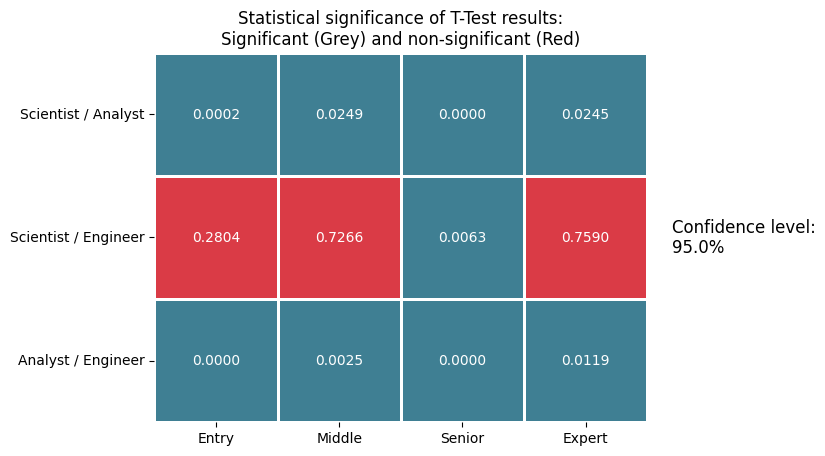

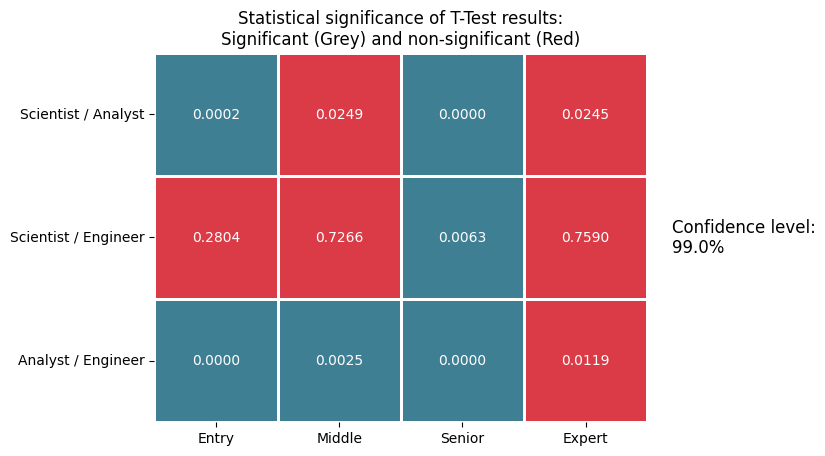

In [130]:
def heatmap_summary(p_thr):
    p_vals = []
    for level in levels:
        p_lvl = multiple_ttest(df[df.experience_level == level], p_thr, False)
        p_vals.append(p_lvl)
    summary_df = pd.DataFrame(p_vals, index=levels, columns=['Scientist / Analyst',
                                                             'Scientist / Engineer',
                                                             'Analyst / Engineer'])
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(summary_df.T, cmap=cmap, center=p_thr, vmin=p_thr-1e-10, vmax=p_thr+1e-10, 
                annot=True, fmt=".4f", linewidths=1, square=True, cbar=False)
    plt.title("Statistical significance of T-Test results:\nSignificant (Grey) and non-significant (Red)")
    plt.text(1.05, 0.5, f"Confidence level:\n{(1-p_thr)*100}%", fontsize=12, 
         transform=plt.gca().transAxes, va='center')
    plt.show()
    
heatmap_summary(0.05)
heatmap_summary(0.01)

In [131]:
fig = go.Figure()

fig.add_trace(go.Box(
    y=df.salary_in_usd,
    x=df.remote_ratio,
    name=job))

fig.update_layout(
    title="Annual salary distribution in US dollars by remote ratio<br><sup>2022/2023</sup>",
    xaxis_title="Remote ratio",
    yaxis_title="Annual salary (USD)",
    boxmode='group')

fig.show()

print(df.remote_ratio.value_counts())


remote_ratio
0      1839
100    1416
50       67
Name: count, dtype: int64


Insights
The salary distribution does not change a lot between 0 and 100% of remote ratio
For 50% of remote ratio, the distribution might be due to the small amount of examples described like this, this might not be representative

Conclusion¶
Data Scientists and Data Engineers have comparable salaries
Data Analyst earn significantly less money than the two others
The remote ratio does not seem to influence the anual salary